# DNS over TLS (DoT) Measurement Analysis

This notebook analyzes the results of DNS over TLS (DoT) measurements stored in `dns_measurements_dot.sqlite`.
It mirrors the analyses from the UDP notebook and adds a section to identify local resolvers that support DoT.


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from sqlite
conn = sqlite3.connect('dns_measurements_dot.sqlite')
df = pd.read_sql_query('SELECT * FROM results', conn)
conn.close()
df.head()

,msm_id,domain,resolver,prb_id,rt,size,src_addr,dst_addr,timestamp,err,err_msg
0,109060048,google.com,local,17909,161.831,68.0,2a02:2c60:f13a:1e0:6666:b3ff:fec4:fed0,2001:4860:4860::8888,1.749744e+09,0,None
1,109060048,google.com,local,17909,162.946,68.0,192.168.168.37,8.8.8.8,1.749744e+09,0,None
2,109060048,google.com,local,17909,158.619,68.0,192.168.168.37,8.8.4.4,1.749744e+09,0,None
3,109060048,google.com,local,1000114,NaN,NaN,None,127.0.0.53,1.749744e+09,1,TU_BAD_ADDR: True
4,109060048,google.com,local,1000201,NaN,NaN,None,185.12.64.1,1.749744e+09,1,timeout: 5000


## 1. Distribution of Successful vs. Erroneous Measurements

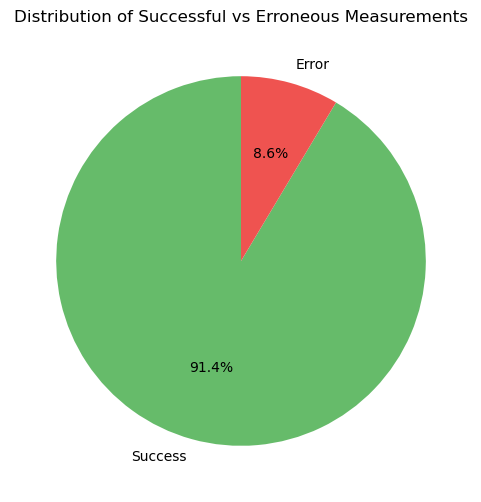

In [2]:
success_counts = df['err'].value_counts()
labels = ['Success', 'Error']
plt.figure(figsize=(6, 6))
plt.pie(success_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66bb6a', '#ef5350'])
plt.title('Distribution of Successful vs Erroneous Measurements')
plt.show()

## 2. Distribution of Different Error Messages (Pie Chart)

/tmp/ipykernel_6413/2914311820.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


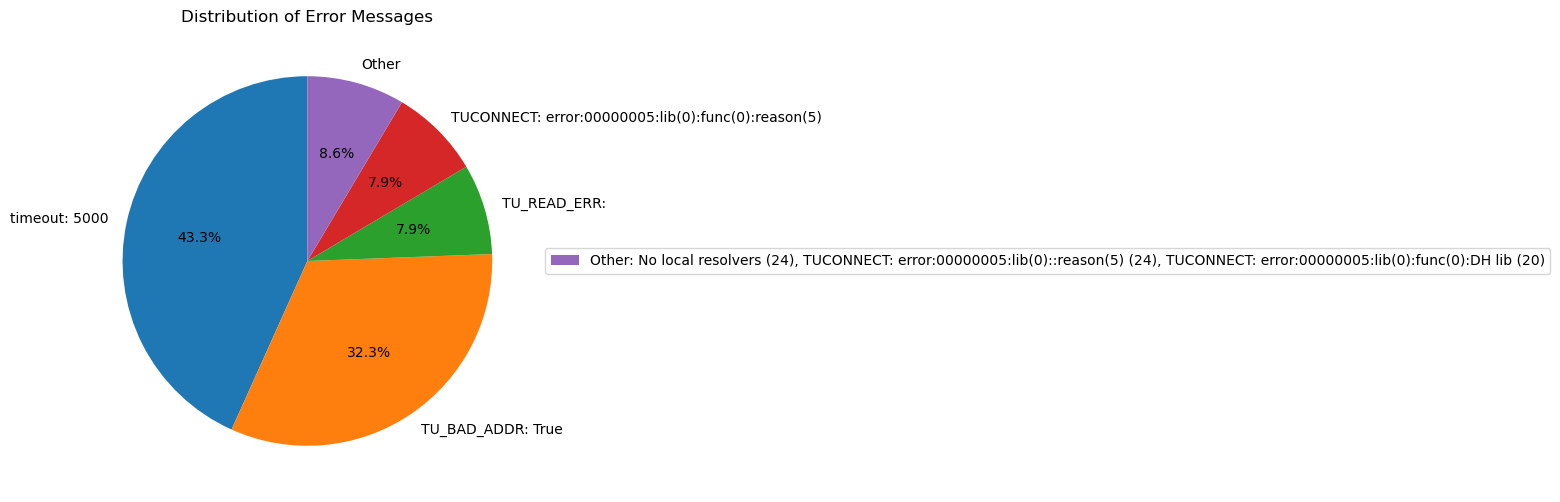

In [3]:
def normalize_err_msg(msg):
    if not isinstance(msg, str):
        msg = str(msg)
    # Gruppiere alle Timeouts
    if "timeout" in msg or "5000" in msg:
        return "timeout: 5000"
    if "Network is unreachable" in msg:
        return "Network unreachable"
    if "Permission denied" in msg:
        return "Permission denied"
    if "no local resolvers found" in msg:
        return "No local resolvers"
    if msg.strip() in ("nan", "", "None", "unknown", "Unknown"):
        return "Unknown"
    return msg

err_msgs = df[df['err'] == 1]['err_msg'].fillna('Unknown').map(normalize_err_msg)
err_counts = err_msgs.value_counts()

threshold = 0.05  # 5%
total = err_counts.sum()
labels = []
sizes = []
other_count = 0
other_labels = []
for label, count in err_counts.items():
    if count / total < threshold:
        other_count += count
        other_labels.append(f"{label} ({count})")
    else:
        labels.append(label)
        sizes.append(count)
if other_count > 0:
    labels.append('Other')
    sizes.append(other_count)

fig, ax = plt.subplots(figsize=(6, 6))
patches, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Error Messages')
if other_count > 0:
    ax.legend([patches[labels.index('Other')]], [f"Other: {', '.join(other_labels)}"], loc='center left', bbox_to_anchor=(1, 0.5))
else:
    ax.legend(patches, [f"{l} ({c})" for l, c in zip(labels, sizes)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## 3. CDF of Response Times by Resolver (Only Successful Measurements)


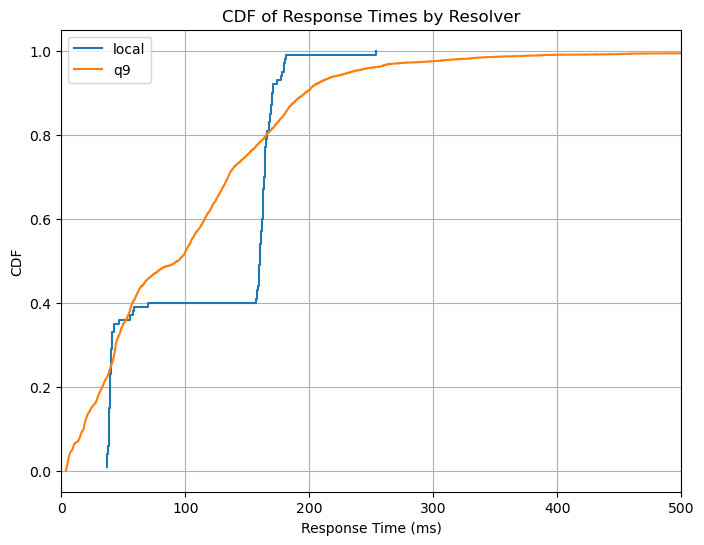

In [4]:
plt.figure(figsize=(8, 6))
for resolver, group in df[(df['err'] == 0) & (df['rt'].notnull())].groupby('resolver'):
    sorted_rt = group['rt'].sort_values()
    y = sorted_rt.rank(method='max', pct=True)
    plt.step(sorted_rt, y, where='post', label=resolver)
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('CDF of Response Times by Resolver')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.show()

## 4. CDF of Response Times by ASN (Only Successful Measurements)

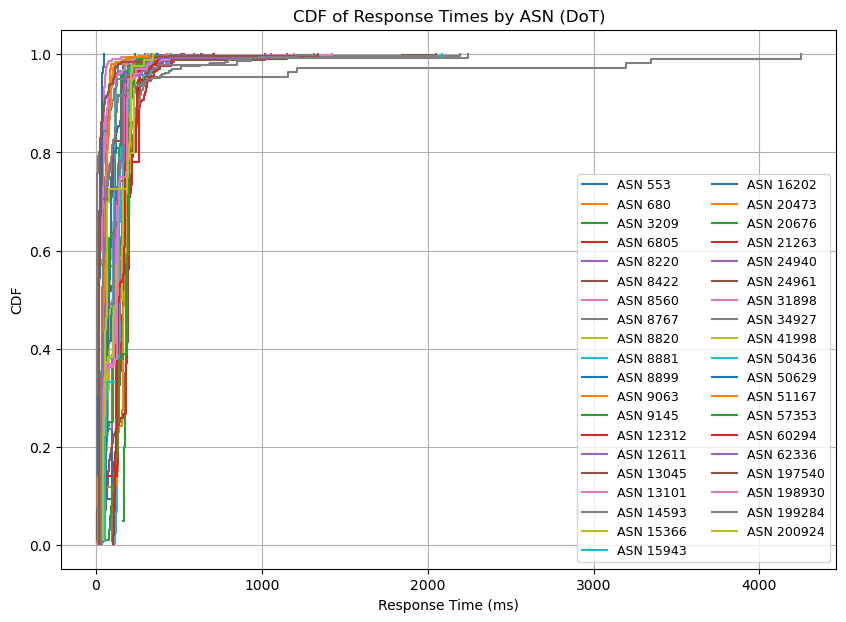

In [5]:
asn_map = pd.read_csv('probe_asn_mapping_dot.csv')
asn_map = asn_map.rename(columns={'probe_id': 'prb_id', 'asn_v4': 'asn'})
df_asn = df.merge(asn_map, on='prb_id', how='left')
plt.figure(figsize=(10, 7))
for asn, group in df_asn[(df_asn['err'] == 0) & (df_asn['rt'].notnull())].groupby('asn'):
    sorted_rt = group['rt'].sort_values()
    y = sorted_rt.rank(method='max', pct=True)
    plt.step(sorted_rt, y, where='post', label=f'ASN {asn}')
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('CDF of Response Times by ASN (DoT)')
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.show()

## 5. CDF of Response Times by Continent (Only Successful Measurements)

**Note:** All probes are from Germany, so only Europe will be present.

For demonstration, we plot the CDF for Germany as a single group.

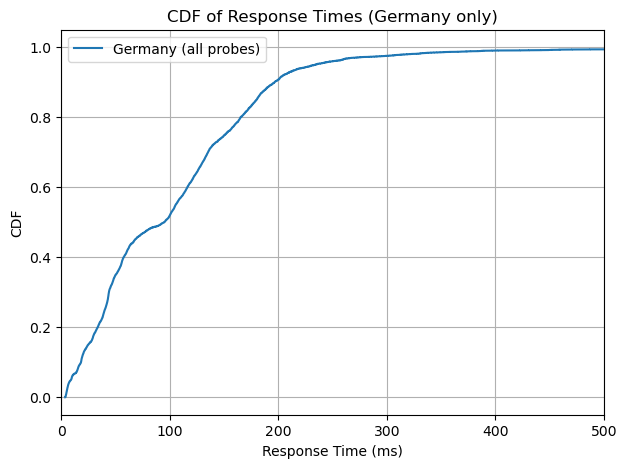

In [6]:
plt.figure(figsize=(7, 5))
df_success = df[(df['err'] == 0) & (df['rt'].notnull())]
sorted_rt = df_success['rt'].sort_values()
y = sorted_rt.rank(method='max', pct=True)
plt.step(sorted_rt, y, where='post', label='Germany (all probes)')
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('CDF of Response Times (Germany only)')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.show()

## 6. Identify Local Resolvers that Support DoT

For all local resolvers with at least one successful DoT response, list their IP addresses, announcing ASNs, and AS holders. Results are saved as `local_dot_resolvers.csv`.

In [7]:
# Filter: local resolver, at least one successful DoT response
local_success = df[(df['resolver'] == 'local') & (df['err'] == 0) & (df['src_addr'].notnull())]
# Get unique resolver IPs
unique_ips = local_success['src_addr'].unique()
# For ASN/holder lookup, use Team Cymru's whois service
import socket
def get_asn_holder(ip):
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.settimeout(3)
        s.connect(('whois.cymru.com', 43))
        s.sendall(f'begin\nverbose\n{ip}\nend\n'.encode())
        data = b''
        while True:
            chunk = s.recv(4096)
            if not chunk: break
            data += chunk
        s.close()
        lines = data.decode().split('\n')
        for line in lines:
            if line.startswith('AS'): continue
            parts = line.split('|')
            if len(parts) >= 5:
                asn = parts[0].strip()
                holder = parts[4].strip()
                return asn, holder
    except Exception as e:
        return None, None
    return None, None

resolver_info = []
for ip in unique_ips:
    asn, holder = get_asn_holder(ip)
    resolver_info.append({'ip': ip, 'asn': asn, 'holder': holder})

resolver_df = pd.DataFrame(resolver_info)
resolver_df.to_csv('local_dot_resolvers.csv', index=False)
resolver_df

,ip,asn,holder
0,2a02:2c60:f13a:1e0:6666:b3ff:fec4:fed0,9063,ripencc
1,192.168.168.37,NA,other
2,172.17.0.2,NA,other


## 7. Compare CDF of Germany response time for DNS over UDP and DoT

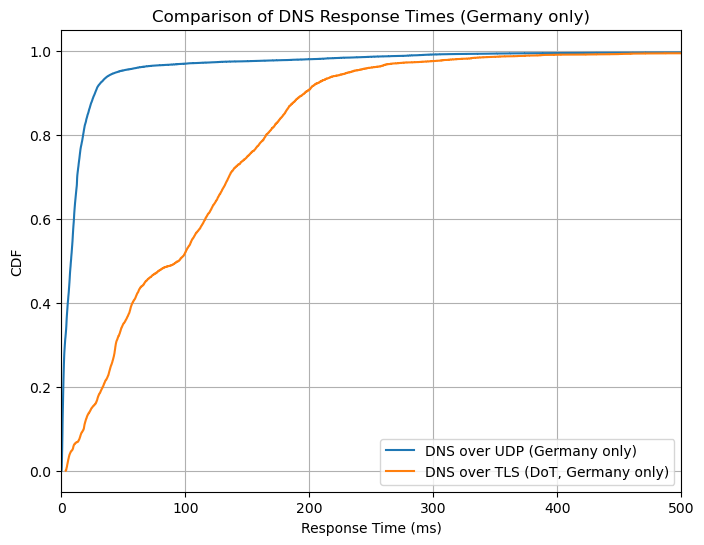

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Load DNS over UDP data
conn_udp = sqlite3.connect('../Task 1/dns_measurements.sqlite')
df_udp = pd.read_sql_query('SELECT * FROM results', conn_udp)
conn_udp.close()

# Load DNS over TLS (DoT) data
conn_dot = sqlite3.connect('dns_measurements_dot.sqlite')
df_dot = pd.read_sql_query('SELECT * FROM results', conn_dot)
conn_dot.close()

# Filter successful measurements with valid response times
df_udp_success = df_udp[(df_udp['err'] == 0) & (df_udp['rt'].notnull())]
df_dot_success = df_dot[(df_dot['err'] == 0) & (df_dot['rt'].notnull())]

# Sort response times
sorted_rt_udp = df_udp_success['rt'].sort_values()
sorted_rt_dot = df_dot_success['rt'].sort_values()

# Calculate CDFs
y_udp = sorted_rt_udp.rank(method='max', pct=True)
y_dot = sorted_rt_dot.rank(method='max', pct=True)

# Plot both CDFs in one figure
plt.figure(figsize=(8, 6))
plt.step(sorted_rt_udp, y_udp, where='post', label='DNS over UDP (Germany only)')
plt.step(sorted_rt_dot, y_dot, where='post', label='DNS over TLS (DoT, Germany only)')
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('Comparison of DNS Response Times (Germany only)')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.show()